## Import necessary packages

In [20]:
# %matplotlib inline
import mpld3
mpld3.enable_notebook()
%matplotlib auto
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import arma_generate_sample, arma_acf
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
os.getcwd()

Using matplotlib backend: MacOSX


'/Users/anestiskaimakamidis/Documents/GitHub/time-series-analysis/assignment-data'

## Utilities

In [2]:
def plot_timeseries(xV, get_histogram=False, title='', savepath=''):
    # #plot timeseries
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    ax.plot(xV, marker='x', linestyle='--', linewidth=2);
    ax.set_xlabel('time')
    ax.set_ylabel('value')
    if len(title) > 0:
        ax.set_title(title, x=0.5, y=1.0);
    plt.tight_layout()
    if len(savepath) > 0:
        plt.savefig(f'{savepath}/{title}_xM.jpeg')
    # #plot histogram
    if get_histogram:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.hist(xV, alpha=0.8, rwidth=0.9);
        ax.set_xlabel('value')
        ax.set_title('Histogram')
        plt.tight_layout()
        if len(title) > 0:
            ax.set_title(title, x=0.5, y=1.0);
        plt.tight_layout()
        if len(savepath) > 0:
            plt.savefig(f'{savepath}/{title}_hist.jpeg')



def read_datfile(path):
    xV = np.loadtxt(path)
    return xV

def rolling_window(xV, window):
    '''
    returns moving average of a time series xV 
    with length of window
    '''
    xV = xV.flatten()
    return np.convolve(xV, np.ones(window)/window, mode='same') 

def polynomial_fit(xV, p):
    '''
    fit to a given time series with a polynomial of a given order.
    :param xV: vector of length 'n' of the time series
    :param p: the order of the polynomial to be fitted
    :return: vector of length 'n' of the fitted time series
    '''
    n = xV.shape[0]
    xV = xV[:]
    if p > 1:
        tV = np.arange(n)
        bV = np.polyfit(x=tV, y=xV, deg=p)
        muV = np.polyval(p=bV, x=tV)
    else:
        muV = np.full(shape=n, fill_value=np.nan)
    return muV


def seasonal_components(xV, period):
    '''
    computes the periodic time series comprised of repetetive
    patterns of seasonal components given a time series and the season
    (period).
    '''
    n = xV.shape[0]
    sV = np.full(shape=(n,), fill_value=np.nan)
    monV = np.full(shape=(period,), fill_value=np.nan)
    for i in np.arange(period):
        monV[i] = np.mean(xV[i:n:period])
    monV = monV - np.mean(monV)
    for i in np.arange(period):
         sV[i:n:period] = monV[i] * np.ones(shape=len(np.arange(i, n, period)))
    return sV



def generate_arma_ts(phiV, thetaV, n, sdnoise=1):
    '''
    Generate an ARMA(p,q) time series of length 'n' with Gaussian input noise.
    Note that phiV = [phi(0) phi(1) ... phi(p)]' and phi(0) is the constant
    term, and thetaV = [theta(1) ... theta(q)]'.
    sdnoise is the SD of the input noise (if left out then sdnoise=1).
    The generating ARMA(p,q) process reads
    x(t) = phi(0) + phi(1)*x(t-1) + ... + phi(p)*x(t-p) +
            +z(t) - theta(1)*z(t-1) + ... - theta(q)*z(t-p),
    z(t) ~ WN(0,sdnoise^2)
    '''
    phiV = np.array(phiV)
    thetaV = np.array(thetaV)
    ar_params = np.r_[1, -phiV[:]]  # add zero lag
    ma_params = np.r_[1, thetaV[:]]  # add zero lag
    xV = arma_generate_sample(ar=ar_params, ma=ma_params, nsample=n, scale=sdnoise, burnin=100)
    return xV
    # q = len(thetaV)
    # p = len(phiV) - 1
    # pq = np.max(p, q)
    # ntrans = 100 + pq
    # phiV = phiV[:]
    # thetaV = thetaV[:]
    # if p > 0:
    #     root_arV = np.roots(np.r_[1, -phiV[1:]])
    #     if np.any(np.abs(root_arV) >= 1):
    #         print(f'The AR({p}) part of the process is not stationary.\n')
    # if q > 0:
    #     root_maV = np.roots(np.r_[1, -thetaV[1:]])
    #     if np.any(np.abs(root_maV) >= 1):
    #         print(f'The MA({p}) part of the process is not stationary.\n')
    # x0V = sdnoise * np.random.normal(size=(pq, 1))
    # zV = sdnoise * np.random.normal(size=(n+ntrans, 1))
    # xV = np.full(shape=(n+ntrans, 1), fill_value=np.nan)
    # xV[:pq] = x0V
    # if p == 0:
    #     for i in np.arange(pq+1, n+ntrans):
    #         xV[i] = phiV[0] + zV[i] - thetaV * np.flipud(zV[i - q:i])
    # elif q == 0:
    #     for i in np.arange(pq+1, n+ntrans):
    #         xV[i] = phiV[0] + phiV[1: p+1] * np.flipud(xV[i-p:i-1]) + zV[i]
    # else:
    #     for i in np.arange(pq+1, n+ntrans):
    #         xV[i] = phiV[0] + phiV[1:p+1] * np.flipud(xV[i-p:i-1]) + zV[i] - thetaV * np.flipud(zV[i-q:i-1])
    # xV = xV[ntrans + 1:]
    # return xV

def add_stochastic_trend(xV):
    '''
    adds a stochastic trend to a given time series (for
    simulating purposes). The time series of stochastic trend is generated by
    simulating a smoothed random walk time series of the same length as that of the
    given time series.
    :param xV: vector of length 'n' of the given time series
    :return: vector of length 'n' of the sum of the given time series and a stochastic trend
    '''
    xV = xV[:]
    n = xV.shape[0]
    maorder = np.round(n // 5)
    x_std = np.std(xV)
    zV = 0.1 * x_std * np.random.normal(0, 1, n)
    zV = np.cumsum(zV)
    wV = rolling_window(zV, window=maorder)
    yV = xV + wV
    return yV

def add_seasonality(xV, period):
    '''
    adds a seasonal component to a given time series (for
    simulating purposes). The time series of seasonality is generated by
    cosine function of a given period 'per' and amplitude equal to the
    standard deviation of the given time series.
    '''
    n = xV.shape[0]
    xV = xV[:]
    x_sd = np.std(xV)
    zV = x_sd * np.cos(2*np.pi*np.arange(n)/period)
    return xV + zV


def armacoefs2autocorr(phiV, thetaV, lags=10):
    '''
    Theoretical autocorrelation function of an ARMA process.
    phiV: The coefficients for autoregressive lag polynomial, not including zero lag.
    thetaV : array_like, 1d
        The coefficients for moving-average lag polynomial, not including zero lag.
    '''
    phiV, thetaV = np.array(phiV), np.array(thetaV)
    phiV = np.r_[1, -phiV] # add zero lag
    thetaV = np.r_[1, thetaV] # #add zero lag
    acf_ = arma_acf(phiV, thetaV, lags=lags)
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    ax.scatter(np.arange(1, lags), acf_[1:], marker='o')
    ax.set_xlabel('Lags')
    ax.set_xticks(np.arange(1, lags))
    ax.set_yticks(np.arange(-1, 1, 0.1))
    ax.set_title('ACF', fontsize=14)
    ax.grid(linestyle='--', linewidth=0.5, alpha=0.15)
    plt.show()
#     for t in np.arange(lags):
#         ax.axvline(t, ymax=acf_[t], color='red', alpha=0.3);

# def macoef2autocorr(phiV, thetaV, lags=10):
#     from statsmodels.tsa.arima_process import arma_pacf
#     pacf_ = arma_pacf(phiV, thetaV, lags=10)
#     fig, ax = plt.subplots(1, 1)
#     ax.scatter(np.arange(lags), pacf_, marker='o');
#     for t in np.arange(lags):
#         ax.axvline(t, ymax=pacf_[t], color='red', alpha=0.3);
        

def plot_3d_attractor(xM):
    '''
    plot 3d attractor
    '''
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xM[:, [0]], xM[:, [1]], xM[:, [2]])
    plt.show()

def embed_data(xV, m=3, tau=1):
    """Time-delay embedding.
    Parameters
    ----------
    x : 1d-array, shape (n_times)
        Time series
    m : int
        Embedding dimension (order)
    tau : int
        Delay.
    Returns
    -------
    embedded : ndarray, shape (n_times - (order - 1) * delay, order)
        Embedded time-series.
    """
    N = len(xV)
    nvec = N - (m-1)*tau
    xM = np.zeros(shape=(nvec, m))
    for i in np.arange(m):
        xM[:, m-i-1] = xV[i*tau:nvec+i*tau]
    return xM

def get_acf(xV, lags=10, alpha=0.05, show=True):
    '''
    calculate acf of timeseries xV to lag (lags) and show
    figure with confidence interval with (alpha)
    '''
    acfV = acf(xV, nlags=lags)[1:]
    z_inv = norm.ppf(1-alpha/2)
    upperbound95 = z_inv / np.sqrt(xV.shape[0])
    lowerbound95 = -upperbound95
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14,8))
        ax.plot(np.arange(1, lags+1), acfV, marker='o')
        ax.axhline(upperbound95, linestyle='--', color='red', label=f'Conf. Int {(1-alpha)*100}%')
        ax.axhline(lowerbound95, linestyle='--', color='red')
        ax.set_title('ACF')
        ax.set_xlabel('Lag')
        ax.set_xticks(np.arange(1, lags+1))
        ax.grid(linestyle='--', linewidth=0.5, alpha=0.15)
        ax.legend()
    return acfV  
	
def get_pacf(xV, lags=10, alpha=0.05, show=True):
    '''
    calculate pacf of timeseries xV to lag (lags) and show
    figure with confidence interval with (alpha)
    '''
    pacfV = pacf(xV, nlags=lags)[1:]
    z_inv = norm.ppf(1-alpha/2)
    upperbound95 = z_inv / np.sqrt(xV.shape[0])
    lowerbound95 = -upperbound95
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14,8))
        ax.plot(np.arange(1, lags+1), pacfV, marker='o')
        ax.axhline(upperbound95, linestyle='--', color='red', label=f'Conf. Int {(1-alpha)*100}%')
        ax.axhline(lowerbound95, linestyle='--', color='red')
        ax.set_title('PACF')
        ax.set_xlabel('Lag')
        ax.set_xticks(np.arange(1, lags+1))
        ax.grid(linestyle='--', linewidth=0.5, alpha=0.15)
        ax.legend()
    return pacfV  

def portmanteau_test(xV, maxtau, show=False):
    '''
    PORTMANTEAULB hypothesis test (H0) for independence of time series:
    tests jointly that several autocorrelations are zero.
    It computes the Ljung-Box statistic of the modified sum of 
    autocorrelations up to a maximum lag, for maximum lags 
    1,2,...,maxtau. 
    '''
    ljung_val, ljung_pval = acorr_ljungbox(xV, lags=maxtau)
    if show:
        fig, ax = plt.subplots(1, 1)
        ax.scatter(np.arange(len(ljung_pval)), ljung_pval)
        ax.axhline(0.05, linestyle='--', color='r')
        ax.set_title('Ljung-Box Portmanteau test')
        ax.set_yticks(np.arange(0, 1.1))
        plt.show()
    return ljung_val, ljung_pval

def fit_arima_model(xV, p, q, d=0, show=False):
    '''
    fit ARIMA(p, d, q) in xV
    returns: summary (table), fittedvalues, residuals, model, AIC
    '''
    model = ARIMA(xV, order=(p, d, q)).fit()
    summary = model.summary()
    fittedvalues = model.fittedvalues
    fittedvalues = np.array(fittedvalues).reshape(-1, 1)
    resid = model.resid
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(xV, label='Original', color='blue')
        ax.plot(fittedvalues, label='FittedValues', color='red', linestyle='--', alpha=0.9)
        ax.legend()
        ax.set_title(f'ARIMA({p}, {d}, {q})')
        fig, ax = plt.subplots(2, 1, figsize=(14, 8))
        ax[0].hist(resid, label='Residual')
        ax[1].scatter(np.arange(len(resid)),resid)
        plt.title('Residuals')
        plt.legend()
    return summary, fittedvalues, resid, model, model.aic

def calculate_fitting_error(xV, model, Tmax=20, show=False):
    '''
    calculate fitting error with NRMSE for given model in timeseries xV
    till prediction horizon Tmax
    returns:
    nrmseV
    preds: for timesteps T=1, 2, 3
    '''
    nrmseV = np.full(shape=Tmax, fill_value=np.nan)
    nobs = len(xV)
    xV_std = np.std(xV)
    vartar = np.sum((xV - np.mean(xV)) ** 2)
    predM = []
    tmin = np.max([len(model.arparams), len(model.maparams), 1]) # start prediction after getting all lags needed from model
    for T in np.arange(1, Tmax):
        errors = []
        predV = np.full(shape=nobs, fill_value=np.nan)
        for t in np.arange(tmin, nobs-T):
            pred_ = model.predict(start=t, end=t+T-1, dynamic=True)
            # predV.append(pred_[-1])
            ytrue = xV[t+T-1]
            predV[t+T-1] = pred_[-1]
            error = pred_[-1] - ytrue
            errors.append(error)
        predM.append(predV)
        errors = np.array(errors)
        mse = np.mean(np.power(errors, 2))
        rmse = np.sqrt(mse)
        nrmseV[T] = (rmse / xV_std)
        # nrmseV[T] = (np.sum(errors**2) / vartar)
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(np.arange(1, Tmax), nrmseV[1:], marker='x', label='NRMSE');
        ax.axhline(1, color='red', linestyle='--');
        ax.set_title('Fitting Error')
        ax.legend()
        ax.set_xlabel('T')
        ax.set_xticks(np.arange(1, Tmax))
        plt.show()
        # #plot multistep prediction for T=1, 2, 3
        fig, ax = plt.subplots(1, 1, figsize=(14,8))
        ax.plot(xV, label='original')
        colors = ['red', 'green', 'black']
        for i, preds in enumerate(predM[:3]):
            ax.plot(preds, color=colors[i], linestyle='--', label=f'T={i+1}', alpha=0.7)
        ax.legend(loc='best')
        plt.show()
    return nrmseV, predM


def predict_multistep(model, Tmax=10, show=False):
    tmin = np.max([len(model.arparams), len(model.maparams), 1]) # start prediction after getting all lags needed from model
    preds = model.predict(start=tmin, end=Tmax, dynamic=True)
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(preds)
        ax.set_title('Multistep prediction')
        ax.set_xlabel('T')
        plt.show
    return preds

def gaussianisation(data):
    '''
    transform a variable of any distribution 
    into normal
    '''
    sort_ind = np.argsort(data)
    gaussian_data = np.random.normal(0, 1, size=data.shape[0])
    gaussian_data_ind = np.argsort(gaussian_data)
    g_d_sorted = gaussian_data[gaussian_data_ind]
    y = np.zeros(shape=data.shape[0])
    for i in np.arange(data.shape[0]):
        y[i] = g_d_sorted[sort_ind[i]]
    return y

def get_nrmse(target, predicted):
    se = (target - predicted)**2
    mse = np.mean(se)
    rmse = np.sqrt(mse)
    return rmse/np.std(target)

def correlationdimension(xV, tau, m_max, fac=4, logrmin=-1e6, logrmax=1e6, show=False):
    m_all = np.arange(1, m_max + 1)
    corrdimV = []
    logrM = []
    logCrM = []
    polyM = []

    for m in m_all:
        corrdim, *corrData = nolds.corr_dim(xV, m, debug_data=True)
        corrdimV.append(corrdim)
        logrM.append(corrData[0][0])
        logCrM.append(corrData[0][1])
        polyM.append(corrData[0][2])
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(m_all, corrdimV, marker='x', linestyle='.-')
        ax.set_xlabel('m')
        ax.set_xticks(m_all)
        ax.set_ylabel('v')
        ax.set_title('Corr Dim vs m')
        
        
    return corrdimV, logrM, logCrM, polyM

## Linear analysis

In [21]:
os.chdir('..//assignment-data')
data = pd.read_csv('MGD50D75D100-first350.dat')
values = data.values
plt.figure()
plt.title('MGD50D75D100 Initial data')
plt.plot(data)

In [4]:
window = 10
ma = rolling_window(xV=values, window=window)
plt.figure()
plt.title('MGD50D75D100 Rolling window')
plt.plot(ma)

In [5]:
diffs = np.log(pd.DataFrame(ma, columns=['MGD50D75D100'])).diff().bfill()
plt.figure()
plt.title('MGD50D75D100 First differences')
plt.plot(diffs)
np.mean(diffs)

MGD50D75D100   -0.001099
dtype: float64

/Users/anestiskaimakamidis/.local/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


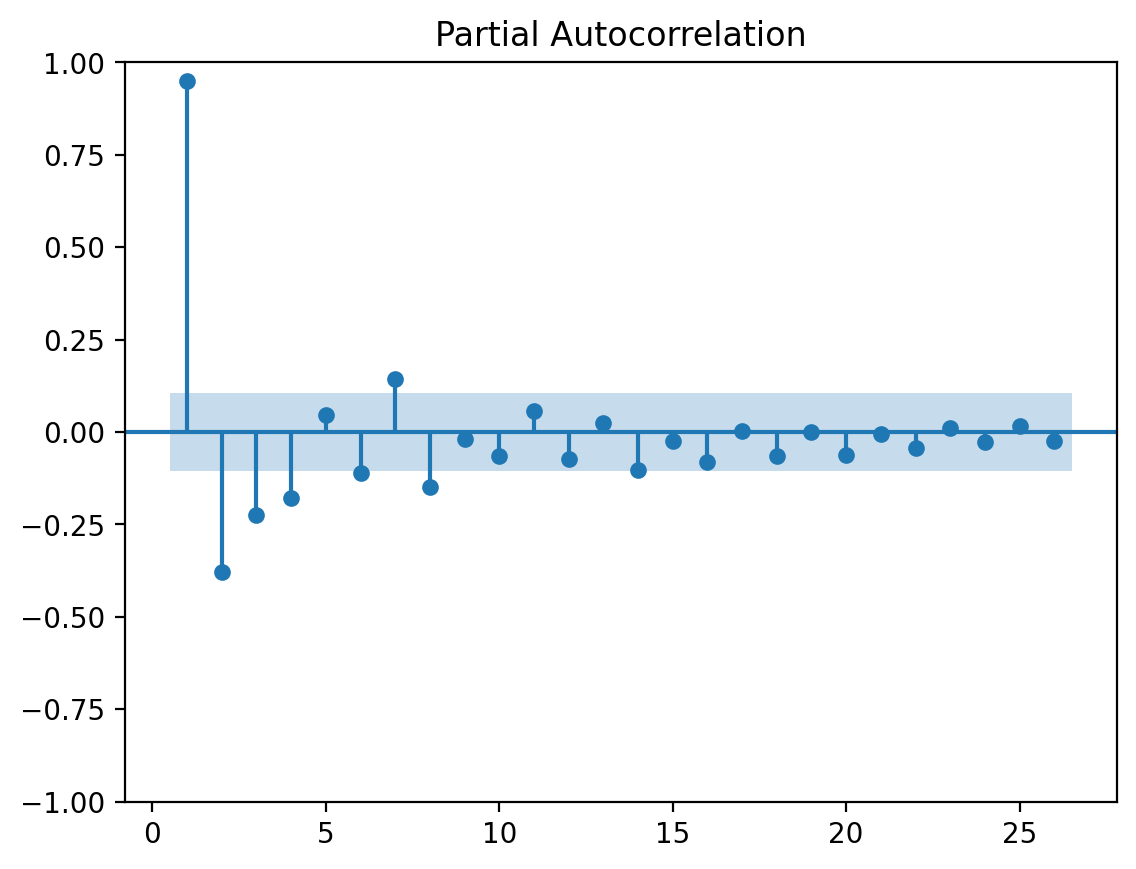

In [6]:
plot_acf(diffs, zero=False)
plot_pacf(diffs, zero=False)

In [22]:
min = float("inf")
best_p = 0
best_q = 0
for p in range(1, 10):
    for q in range(1, 10):
        _, _, _, _, aic = fit_arima_model(diffs, p=p, q=q, d=0)
        if aic < min:
            min = aic
            best_p = p
            best_q = q

/Users/anestiskaimakamidis/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/anestiskaimakamidis/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/anestiskaimakamidis/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/anestiskaimakamidis/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/anestiskaimakamidis/.local/lib/python3.7/site-packages/statsmodels/tsa/states

In [23]:
print(best_p, best_q, min)

2 3 -2271.4474460658894


In [24]:
n = len(diffs)
test_num = int(0.1 * n) # population of the testing set.

In [25]:
training_set1 = diffs[:n-test_num]
summary, fittedvalues, resid, model, model.aic = fit_arima_model(training_set1, p=best_p, q=best_q, d=0, show=True)
model.aic

/Users/anestiskaimakamidis/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/anestiskaimakamidis/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-2146.382602252192

In [26]:
predictions = model.forecast(test_num)
predictions = predictions.values

predictions[0] = predictions[0] + values[n-test_num-1]
for i in range(1, test_num):
    predictions[i] = predictions[i] + predictions[i-1]

plt.figure()
plt.title('MGD50D75D100 Out of sample predictions')
plt.plot(predictions)
plt.plot(values[n-test_num:])
plt.legend(["predictions", "testing set"])

In [27]:
from sklearn.utils import shuffle
bootstraps = []
for i in range(40):
    bootstraps.append(shuffle(resid))

In [28]:
import nolds
acfs = []
pacfs = []
for i in range(40):
  acfs.append(get_acf(bootstraps[i], show=False))
  pacfs.append(get_pacf(bootstraps[i], show=False))

minmaxa = []
for i in range(10):
  minmaxa.append([float("inf"), -float("inf")])
for i in range(10):
  for j in range(40):
    if acfs[j][i] < minmaxa[i][0]:
      minmaxa[i][0] = acfs[j][i]
    if acfs[j][i] > minmaxa[i][1]:
      minmaxa[i][1] = acfs[j][i]


minmaxp = []
for i in range(10):
  minmaxp.append([float("inf"), -float("inf")])
for i in range(10):
  for j in range(40):
    if acfs[j][i] < minmaxp[i][0]:
      minmaxp[i][0] = acfs[j][i]
    if acfs[j][i] > minmaxp[i][1]:
      minmaxp[i][1] = acfs[j][i]

minmaxm = []
for i in range(5):
  minmaxm.append([float("inf"), -float("inf")])
for i in range(5):
  for j in range(40):
    m, _, _, _ = correlationdimension(bootstraps[j], tau=1, m_max=5)
    if m[i] < minmaxm[i][0]:
      minmaxm[i][0] = m[i]
    if m[i] > minmaxm[i][1]:
      minmaxm[i][1] = m[i]

m, _, _, _ = correlationdimension(resid, tau=1, m_max=10)
plt.figure()
plt.title('MGD50D75D100 Correlation dimension interval')
plt.plot(minmaxm)
plt.plot(m[:5])
plt.legend(['minima', 'maxima', 'extracted from model'])
  
plt.figure()
plt.title('MGD50D75D100 Autocorrelation interval')
plt.plot(minmaxa)
plt.plot(get_acf(resid, show=False))
plt.legend(['minima', 'maxima', 'extracted from model'])

plt.figure()
plt.title('MGD50D75D100 Partial autocorrelation interval')
plt.plot(minmaxp)
plt.plot(get_pacf(diffs, show=False))
plt.legend(['minima', 'maxima', 'extracted from model'])